# Multivariate Time-Series Forecasting: Predict Iron Prices

### Import libs

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from pylab import rcParams


from sklearn.preprocessing import StandardScaler

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam



## ||||||||||||||||||||||||||||||| Part 1: Data preprocessing |||||||||||||||||||||||||||||||

###  Read and load the data; we want to select the features for the training and prediction and extract the date column then make it the index

Index & Date columns...

check for null values:

In [2]:
# import training dataset
dataset_train= pd.read_excel(r'C:\Users\fnafisa\WORKSPACE\professional\Project PoC\Input\data\Construction materials\segregated\حديد تسليح 12مم وطني.xlsx')
dataset_train= dataset_train.sort_values(by=['date'], ascending=True)

# features selection
cols= list(dataset_train)[1:]


# Extract dates (timestamp format)
datelist_train = list(dataset_train['date'])
# datelist_train = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist_train]


# dataset_train.index= dataset_train.pop('date')
print(dataset_train)
print('Training set shape == {}'.format(dataset_train.shape))
print('All timestamps == {}'.format(len(datelist_train)))
print('Featured selected: {}'.format(cols))
print('Sample of date list: {}...{}'.format(datelist_train[0:2], datelist_train[-3:-1]))

          date     price  oil_brent       tasi      gold  interest_rate  \
0   2013-01-01  2964.917     114.54   7,043.55  1,662.00           0.14   
1   2013-02-01  2964.750     110.42   6,998.33  1,578.90           0.15   
2   2013-03-01  2964.942     109.79   7,125.73  1,595.70           0.14   
3   2013-04-01  2964.917     102.04   7,179.80  1,472.70           0.15   
4   2013-05-01  2964.917     100.20   7,404.12  1,393.00           0.11   
..         ...       ...        ...        ...       ...            ...   
112 2022-05-01  4000.960     115.60  12,921.74  1,848.40           0.77   
113 2022-06-01  3704.880     109.03  11,523.25  1,812.00           1.21   
114 2022-07-01  3595.940     103.97  12,199.08  1,771.50           1.68   
115 2022-08-01  3288.840      95.64  12,283.33  1,721.40           2.33   
116 2022-09-01  3116.300      85.14  11,405.32  1,672.00           2.56   

     historical  
0    2615.09244  
1    2964.91700  
2    2964.75000  
3    2964.94200  
4    2964

###  Shaping and transformation

In [3]:

# dataset traing will be the essanse of all the upcoming datasets(training_set, training_set_scaled, X_train, y_train...)
# make sure there are no commas in any number                                                      "Target"      |--------------------"Predictors"-------------------|
dataset_train = dataset_train[cols].astype(str) # to remove the date and select only the features : ['price', 'oil_brent', 'tasi', 'gold', 'interest_rate', 'historical']
for i in cols:
    for j in range(0, len(dataset_train)):
        dataset_train[i][j] = dataset_train[i][j].replace(',', '')

dataset_train = dataset_train.astype(float)

# by using multiple predictors (features) we need to convert (reshape) to a matrix(array) using .to_numpy
training_set= dataset_train.to_numpy()



# Feature scaling hence features vary in range
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)

sc_predict = StandardScaler()
target_scaled= sc_predict.fit_transform(training_set[:, 0:1])



print('Shape of training set        == {}.'.format(training_set.shape))
print('Shape of training set scaled == {}.'.format(training_set_scaled.shape))


Shape of training set        == (117, 6).
Shape of training set scaled == (117, 6).


## ||||||||||||||||||||||||||||||| Part 2: Modeling |||||||||||||||||||||||||||||||

###  Build the model architecture and Set up the WINDOWED DATAFRAME 

In [4]:
# Create a data structure with timestamps
# Target/features selection
X_train= []
y_train= []
n_future= 6 # number of moths to be predicted
n_past= 12 # the size of the windowed dataframe

for i in range(n_past, len(training_set_scaled) - n_future +1):
    X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1]])
    y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])


X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))





X_train shape == (100, 12, 6).
y_train shape == (100, 1).


In [ ]:
# build the model
model= Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
model.add(Dropout(.25))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.10))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.02), loss= 'mean_squared_error')

### Buile the model and  train it...

In [308]:
# build the model
model= Sequential()
model.add(LSTM(units=64, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))
model.add(Dropout(.5))
model.add(LSTM(units=10, return_sequences=False))
model.add(Dropout(.3))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer= Adam(learning_rate=.01), loss= 'mean_squared_error')

# %%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=False, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=16)
# history = model.fit(X_train, y_train, epochs=50, callbacks=[es, rlr, mcp, tb], validation_split=0.3, verbose=1, batch_size=32)

Epoch 1/50
1/5 [=====>........................] - ETA: 9s - loss: 0.2665
Epoch 1: val_loss improved from inf to 1.11116, saving model to weights.h5
5/5 [==============================] - 3s 165ms/step - loss: 0.4321 - val_loss: 1.1112 - lr: 0.0100
Epoch 2/50
1/5 [=====>........................] - ETA: 0s - loss: 0.4955
Epoch 2: val_loss did not improve from 1.11116
5/5 [==============================] - 0s 19ms/step - loss: 0.2634 - val_loss: 1.1290 - lr: 0.0100
Epoch 3/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1699
Epoch 3: val_loss improved from 1.11116 to 0.96372, saving model to weights.h5
5/5 [==============================] - 0s 21ms/step - loss: 0.3110 - val_loss: 0.9637 - lr: 0.0100
Epoch 4/50
1/5 [=====>........................] - ETA: 0s - loss: 0.1327
Epoch 4: val_loss improved from 0.96372 to 0.89117, saving model to weights.h5
5/5 [==============================] - 0s 21ms/step - loss: 0.2364 - val_loss: 0.8912 - lr: 0.0100
Epoch 5/50
1/5 [=====>.........

## ||||||||||||||||||||||||||||||| Part 3: Forcasting |||||||||||||||||||||||||||||||

Create indexes for prediction

In [87]:
# Generate list of sequence of months for predictions w datetime type
datelist_future = pd.date_range(datelist_train[-1], periods=n_future, freq='1m').tolist()
datelist_future_= []
for d in datelist_future:
    d= d + dt.timedelta(days=1)
    d= d.date()
    datelist_future_.append(d)
datelist_future= datelist_future_
del datelist_future_

datelist_train_= []
for this_timestamp in datelist_train:
    datelist_train_.append(this_timestamp.date())
datelist_train= datelist_train_
del datelist_train_

AttributeError: 'datetime.date' object has no attribute 'date'

## Step 5: Make PREDICTION!

In [309]:
# Perform predictions
predictions_train = model.predict(X_train[n_past:])
predictions_future = model.predict(X_train[-n_future:])


y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)


1/1 [==============================] - 0s 19ms/step


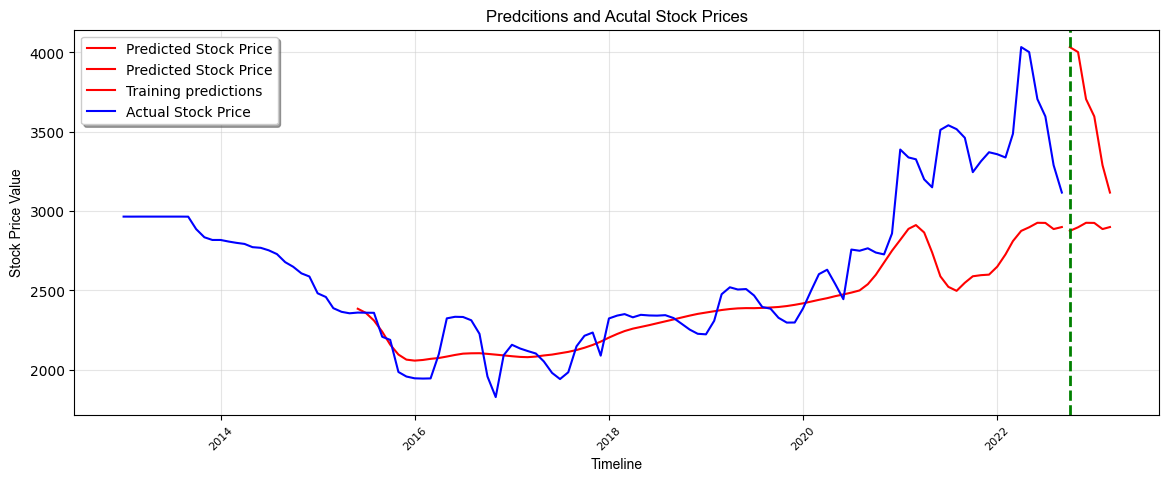

In [310]:
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['predicted_forecast']).set_index(pd.Series(datelist_future))
PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=['predicted_training']).set_index(pd.Series(datelist_train[2 * n_past + n_future -1:]))
dataset_train.index= datelist_train
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5

# Plot parameters
START_DATE_FOR_PLOTTING = '2013-01-01'

plt.plot(PREDICTIONS_FUTURE.index, PREDICTIONS_FUTURE['predicted_forecast'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTIONS_FUTURE_.index, PREDICTIONS_FUTURE_['predicted_forecast'], color='r', label='Predicted Stock Price')
plt.plot(PREDICTION_TRAIN.loc[:].index, PREDICTION_TRAIN.loc[:]['predicted_training'], color='r', label='Training predictions')
plt.plot(dataset_train.loc[:].index, dataset_train.loc[:]['price'], color='b', label='Actual Stock Price')

plt.axvline(x = min(PREDICTIONS_FUTURE.index), color='green', linewidth=2, linestyle='--')

plt.grid(which='major', color='#cccccc', alpha=0.5)

plt.legend(shadow=True)
plt.title('Predcitions and Acutal Stock Prices', family='Arial', fontsize=12)
plt.xlabel('Timeline', family='Arial', fontsize=10)
plt.ylabel('Stock Price Value', family='Arial', fontsize=10)
plt.xticks(rotation=45, fontsize=8)
plt.show()


In [259]:
x= len(PREDICTION_TRAIN)
last_insight= np.array(dataset_train['price'][-x:])
last_prediction= np.array(PREDICTION_TRAIN['predicted_training'][:])
factor= (last_insight - last_prediction) / last_prediction
# factor= factor.mean()

In [260]:
b= np.empty(n_future)
b.fill(float(factor))
b

TypeError: only size-1 arrays can be converted to Python scalars

In [276]:
a= (last_prediction[-6:] * factor[-6:]) + last_prediction[-6:]


In [277]:
a

array([4032.6 , 4000.96, 3704.88, 3595.94, 3288.84, 3116.3 ])

In [278]:
PREDICTIONS_FUTURE_= pd.DataFrame(a, columns=['predicted_forecast'], index=PREDICTIONS_FUTURE.index)

In [279]:
PREDICTIONS_FUTURE_

,predicted_forecast
2022-10-01,4032.60
2022-11-01,4000.96
2022-12-01,3704.88
2023-01-01,3595.94
2023-02-01,3288.84
2023-03-01,3116.30
